In [1]:
import torch
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import os
from tensorboardX import SummaryWriter 
from tqdm import tqdm
import numpy as np
from torchvision import datasets

In [2]:
IMAGE_SIZE=(100,100)
LR = 0.001    
BATCH_SIZE=64
EPOCHS=1000
EARLY_STOP_Threshold=5

In [3]:
# Input Data

In [4]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((100,100)),
                                      transforms.ToTensor(),
                                      
                                      transforms.ColorJitter(),
                                      transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((100,100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((100,100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [5]:
# choose the training and test datasets
train_data = datasets.ImageFolder('data/train', transform=train_transforms)
val_data = datasets.ImageFolder('data/val',transform=valid_transforms)

In [6]:
class_dir=train_data.class_to_idx
#print(class_dir)

In [7]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = list(class_dir.keys())
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

/home/highsunday/anaconda3/envs/python_yolo/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


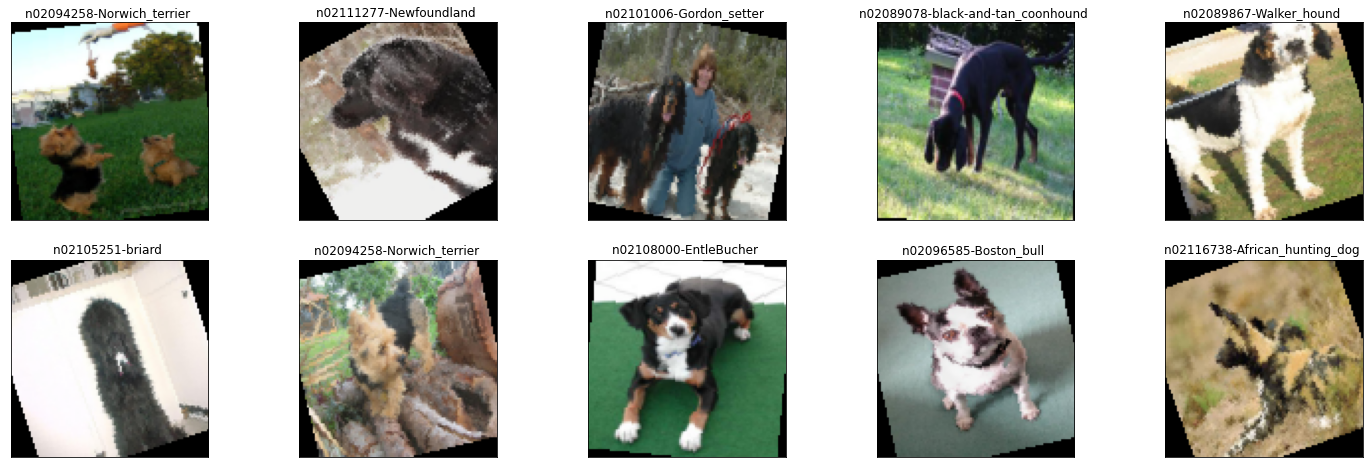

In [9]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)
print("train_loader:",len(train_loader))
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True)
print("val_loader:",len(valid_loader))

train_loader: 247
val_loader: 57


In [11]:
# Define Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F     # 激励函数都在这

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (3, 100, 100)
            nn.Conv2d(
                in_channels=3,      # input height
                out_channels=64,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
            ),      # output shape (32, 100, 100)
            nn.ReLU(),    # activation
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (64, 50, 50)
        )
        self.conv2 = nn.Sequential(  # input shape (64, 50, 50)
            nn.Conv2d(64, 128, 3, 1, 1,bias=False),      # output shape (128, 50, 50)
            nn.ReLU(),    # activation
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 1, 1,bias=False),      # output shape (128, 50, 50)
            nn.ReLU(),    # activation
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (128, 25, 25)
        )
        self.out1 = nn.Linear(128 * 25 * 25, 240)   # fully connected layer, output 120 classes
        self.batchNorm = nn.BatchNorm1d(240)
        self.relu1 = nn.ReLU()
        self.out2 = nn.Linear(240, 120)   # fully connected layer, output 120 classes
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 50 * 50)
        x =  self.out1(x)
        x = self.relu1(x)
        x = self.batchNorm(x)
        output = self.out2(x)
        
        return output
    

In [14]:
# training model

In [15]:
cnn = CNN()
cnn.cuda()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out1): Linear(in_features=80000, out_features=240, bias=True)
  (batchNorm): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (out2): Linear(in_featur

In [16]:
from torchsummary import summary
summary(cnn.cuda(), (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           4,864
              ReLU-2         [-1, 64, 100, 100]               0
       BatchNorm2d-3         [-1, 64, 100, 100]             128
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5          [-1, 128, 50, 50]          73,728
              ReLU-6          [-1, 128, 50, 50]               0
       BatchNorm2d-7          [-1, 128, 50, 50]             256
            Conv2d-8          [-1, 128, 50, 50]         147,456
              ReLU-9          [-1, 128, 50, 50]               0
      BatchNorm2d-10          [-1, 128, 50, 50]             256
        MaxPool2d-11          [-1, 128, 25, 25]               0
           Linear-12                  [-1, 240]      19,200,240
             ReLU-13                  [-1, 240]               0
      BatchNorm1d-14                  [

In [17]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
#optimizer = torch.optim.RMSprop(cnn.parameters())   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

In [18]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
model_name=run_logdir.split("/")[-1]
run_logdir

'./my_logs/run_2021_01_07-00_19_55'

In [19]:
from torch.autograd import Variable
# training and testing
writer = SummaryWriter(run_logdir)
Max_val_accuracy=0
no_improve_count=0
for epoch in range(EPOCHS):
    train_loss=0.0
    val_loss=0.0
    #train_accuracy=0.0
    #val_accuracy=0.0
    train_correct = 0.
    train_total = 0.
    val_correct = 0.
    val_total = 0.
    
    for step, (x, y) in enumerate(tqdm(train_loader)):   # 分配 batch data, normalize x when iterate train_loader
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()
        
        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        #print("loss:",loss)
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()               # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        train_loss+=loss.item()*x.size(0)
        
        pred = output.data.max(1, keepdim=True)[1].cpu()
        # compare predictions to true label
        train_correct += np.sum(np.squeeze(pred.eq(y.data.view_as(pred))).cpu().numpy())
        train_total += x.size(0)
    
    for step, (x, y) in enumerate(valid_loader):  # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()
        # 打出来一些数据
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        val_loss+=loss.item()*x.size(0)
         
        pred = output.data.max(1, keepdim=True)[1].cpu()
        # compare predictions to true label
        
        val_correct += np.sum(np.squeeze(pred.eq(y.data.view_as(pred))).cpu().numpy())
        val_total += x.size(0)
        
    train_loss = train_loss/len(train_loader.dataset)
    val_loss=val_loss/len(valid_loader.dataset)
    train_accuracy=round((100. *train_correct / train_total),3)
    val_accuracy=round((100. *val_correct / val_total),3)
    writer.add_scalars('loss', {'train_loss':train_loss,'valid_loss':val_loss}, epoch)
    writer.add_scalars('accuracy', {'train_accuracy':train_accuracy,'valid_accuracy':val_accuracy}, epoch)
    print('epoch ',epoch,' , train loss : ',train_loss,', train_accuracy:',train_accuracy,' , valid loss :',val_loss,', val_accuracy:',val_accuracy)
    
    if(val_accuracy>Max_val_accuracy):
        Max_val_accuracy=val_accuracy
        no_improve_count=0
        torch.save(cnn.state_dict(), run_logdir+'_weights.pkl')
        print("save model, current best val_accuracy:",Max_val_accuracy)
    else:
        no_improve_count+=1
    if(no_improve_count>=EARLY_STOP_Threshold):
        break


  0%|          | 0/247 [00:00<?, ?it/s]

epoch  0  , train loss :  4.464177607855376 , train_accuracy: 4.759  , valid loss : 4.261267481909858 , val_accuracy: 6.444
save model, current best val_accuracy: 6.444


100%|██████████| 247/247 [02:36<00:00,  1.58it/s]


epoch  1  , train loss :  4.055819324187222 , train_accuracy: 9.259  , valid loss : 4.041350382698907 , val_accuracy: 9.944


  0%|          | 0/247 [00:00<?, ?it/s]

save model, current best val_accuracy: 9.944


100%|██████████| 247/247 [02:44<00:00,  1.50it/s]


epoch  2  , train loss :  3.7874636800730817 , train_accuracy: 12.916  , valid loss : 3.8879828124576146 , val_accuracy: 11.722


  0%|          | 0/247 [00:00<?, ?it/s]

save model, current best val_accuracy: 11.722


100%|██████████| 247/247 [02:46<00:00,  1.49it/s]


epoch  3  , train loss :  3.5369790730741406 , train_accuracy: 17.016  , valid loss : 3.7719049400753444 , val_accuracy: 13.306


  0%|          | 0/247 [00:00<?, ?it/s]

save model, current best val_accuracy: 13.306


100%|██████████| 247/247 [02:40<00:00,  1.53it/s]


epoch  4  , train loss :  3.285035415629227 , train_accuracy: 22.055  , valid loss : 3.6961716906229656 , val_accuracy: 15.139


  0%|          | 0/247 [00:00<?, ?it/s]

save model, current best val_accuracy: 15.139


100%|██████████| 247/247 [02:44<00:00,  1.50it/s]


epoch  5  , train loss :  3.024656803271444 , train_accuracy: 26.89  , valid loss : 3.619802820417616 , val_accuracy: 17.028


  0%|          | 0/247 [00:00<?, ?it/s]

save model, current best val_accuracy: 17.028


100%|██████████| 247/247 [01:11<00:00,  3.44it/s]


epoch  6  , train loss :  2.729968379769113 , train_accuracy: 33.063  , valid loss : 3.611796646118164 , val_accuracy: 18.583


  0%|          | 0/247 [00:00<?, ?it/s]

save model, current best val_accuracy: 18.583


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


epoch  7  , train loss :  2.4661492631269035 , train_accuracy: 39.267  , valid loss : 3.6126362503899467 , val_accuracy: 19.639


  0%|          | 0/247 [00:00<?, ?it/s]

save model, current best val_accuracy: 19.639


  0%|          | 0/247 [00:00<?, ?it/s]

epoch  8  , train loss :  2.1895867923765824 , train_accuracy: 45.592  , valid loss : 3.6843056858910455 , val_accuracy: 19.556


  0%|          | 0/247 [00:00<?, ?it/s]

epoch  9  , train loss :  1.9275112235808267 , train_accuracy: 52.215  , valid loss : 3.7653133328755697 , val_accuracy: 18.972


  0%|          | 0/247 [00:00<?, ?it/s]

epoch  10  , train loss :  1.6920754951823007 , train_accuracy: 57.665  , valid loss : 3.923723996480306 , val_accuracy: 19.361


  0%|          | 0/247 [00:00<?, ?it/s]

epoch  11  , train loss :  1.4602996937199173 , train_accuracy: 63.344  , valid loss : 3.9867738744947645 , val_accuracy: 19.167


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


epoch  12  , train loss :  1.294138202294627 , train_accuracy: 67.558  , valid loss : 4.071113033294678 , val_accuracy: 19.528


In [20]:
#回復最佳model
cnn = CNN()
cnn.load_state_dict(torch.load(run_logdir+'_weights.pkl'))
cnn.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out1): Linear(in_features=80000, out_features=240, bias=True)
  (batchNorm): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (out2): Linear(in_featur

In [21]:
#torch.save(cnn, model_name+'.pkl')
torch.save(cnn.state_dict(), model_name+'_weights.pkl')

In [22]:
# test all

In [23]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [24]:
test_transforms = transforms.Compose([transforms.Resize((100,100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [25]:
test_data = datasets.ImageFolder('data/test', transform=test_transforms)

In [26]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [27]:
use_cuda = torch.cuda.is_available()
cnn=cnn.cuda()
test(test_loader, cnn, loss_func, use_cuda)

Test Loss: 3.569808
Test Accuracy: 21% (254/1200)


In [28]:
test(train_loader, cnn, loss_func, use_cuda)

Test Loss: 2.153840
Test Accuracy: 48% (7592/15779)
